# Customer Segmentation for Online Retail

**The task is to analyze customer data from an online retail platform to segment customers based on their purchasing behavior, preferences, and demographics. The goal is to gain insights into distinct customer segments and tailor marketing strategies to target each segment effectively.**

In [1]:
#importing libraries
import numpy as np
import pandas as pd

# Loading Dataset

In [2]:
df=pd.read_excel('Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Analyzing the Data

**# customer segmentation is performed on available data (remove the data where the transactions were cancelled or returned)**

In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# drop rows with any missing values
df.dropna(inplace=True)

In [8]:
# recheck
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


**Now the dataset seems all good. Since we are looing into customer segmentation, we will transform the current sales data to customer level. Here we will use the RFM marketing analysis, to look at customer's behaviours based on:**

**1.Recency - How many days had passed since customer last purchased.**

**2.Frequency - How many times a customer had shopped here.**

**3.Monetary Value - How much money had the customer spent.**

In [9]:
# RFM feature engineering
# get the total price of each order
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# create customer df and features
customer_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
                                            'InvoiceNo': 'count',
                                            'TotalPrice': 'sum'})

# rename the features
customer_df.rename(columns={'InvoiceDate': 'recency',
                            'InvoiceNo': 'frequency',
                            'TotalPrice': 'monetary'}, inplace=True)

customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4372 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4372 non-null   int64  
 1   frequency  4372 non-null   int64  
 2   monetary   4372 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 136.6 KB


In [10]:
customer_df.sample(10)

,recency,frequency,monetary
CustomerID,,,
17736.0,8,26,337.49
13107.0,43,60,1524.07
18287.0,42,70,1837.28
14950.0,8,20,361.25
15862.0,7,147,832.88
17519.0,16,83,1839.07
15021.0,8,479,1872.28
15713.0,142,20,346.75
14216.0,2,59,1839.30


**Now we have a customer df that includes features that will help us understand each customers purchase behavior.**

In [11]:
customer_df.describe()

,recency,frequency,monetary
count,4372.000000,4372.000000,4372.000000
mean,91.047118,93.053294,1898.459701
std,100.765435,232.471608,8219.345141
min,0.000000,1.000000,-4287.630000
25%,16.000000,17.000000,293.362500
50%,49.000000,42.000000,648.075000
75%,142.000000,102.000000,1611.725000
max,373.000000,7983.000000,279489.020000


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

C:\Users\NEWHP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


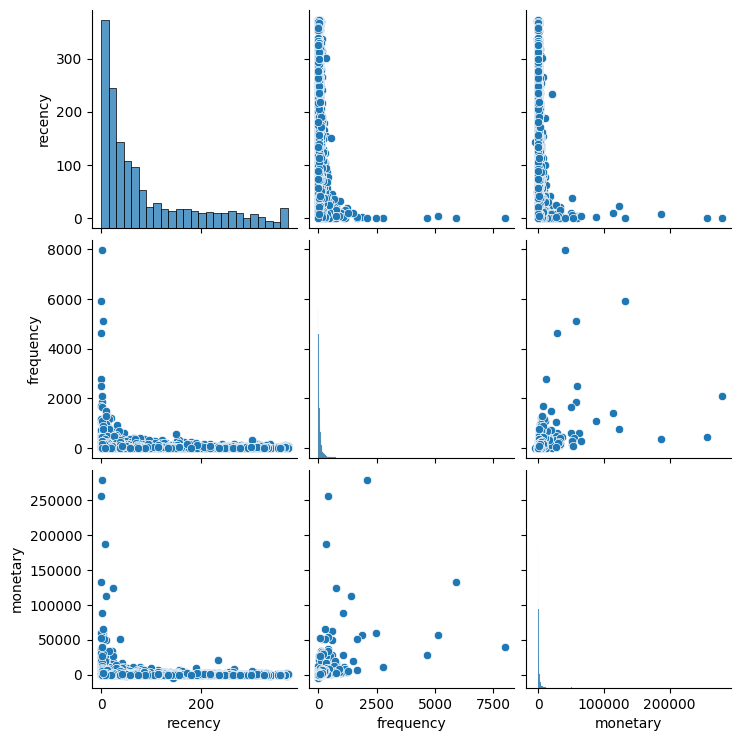

In [13]:
sns.pairplot(customer_df)

# Preprocessing
**Since Kmeans clustering is very sensitive to scale of the variables, and the above description and pairplot suggests the data is not normally disributed and there exist obvious difference in scale and variace between each features, we will have to normalize the data.**

In [14]:
# We choose to use minmaxscaler because we are mostly looking to normalize the data and not looking for a mean equal to zero.
scaler = MinMaxScaler()

norm_customer = scaler.fit_transform(customer_df)

print(norm_customer)

[[8.71313673e-01 1.25281884e-04 1.51091712e-02]
 [2.68096515e-03 2.26760210e-02 3.02971721e-02]
 [1.98391421e-01 3.75845653e-03 2.14424619e-02]
 ...
 [1.87667560e-02 1.50338261e-03 1.57314917e-02]
 [8.04289544e-03 9.45878226e-02 2.24913149e-02]
 [1.12600536e-01 8.64445001e-03 2.15835588e-02]]


# Kmeans clustering

In [15]:
# fit model with different num of clsuters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=33)
    kmeans.fit(norm_customer)
    sse.append(kmeans.inertia_) # sse of the centroid of cluster

**To select the most suitable hyperparameter, we use sum of squared error to measure the variations within each cluser.**

Text(0, 0.5, 'sse')

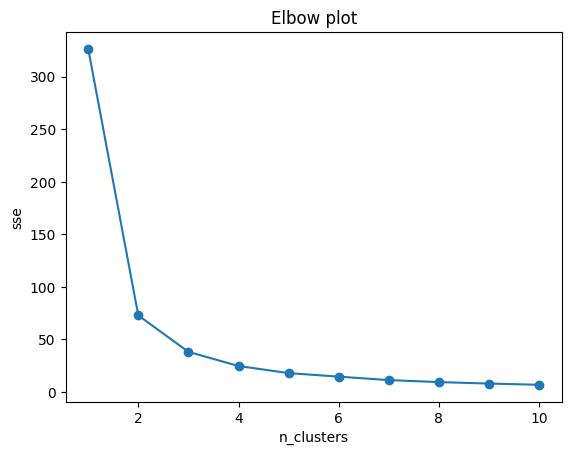

In [16]:
# create sse elbow plot 
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow plot')
plt.xlabel('n_clusters')
plt.ylabel('sse')

**There is a rapid increase of performance when n_cluster went from 1 to 2, yet after 3 clsuters, the performance maitained roughly at the same level. We can choose between 2 and 3 clusters and here we keep the n_clsuter at 3.**

In [17]:
# create the final kmeans model
fin_kmeans = KMeans(n_clusters=3, n_init=10, random_state=33)

fin_kmeans.fit(norm_customer)

KMeans(n_clusters=3, n_init=10, random_state=33)

In [18]:
fin_df = pd.DataFrame(norm_customer, columns=customer_df.columns, index=customer_df.index)

fin_df['cluster'] = fin_kmeans.labels_
fin_df

,recency,frequency,monetary,cluster
CustomerID,,,,
12346.0,0.871314,0.000125,0.015109,1
12347.0,0.002681,0.022676,0.030297,2
12348.0,0.198391,0.003758,0.021442,2
12349.0,0.048257,0.009020,0.021303,2
12350.0,0.828418,0.002005,0.016288,1
...,...,...,...,...
18280.0,0.742627,0.001128,0.015746,1
18281.0,0.482574,0.000752,0.015394,0
18282.0,0.018767,0.001503,0.015731,2


# Characteristics evaluation
**Now let's have a look at the characteristics of each cluster, and see what customer insight we can obtain and try to answer our questions.**

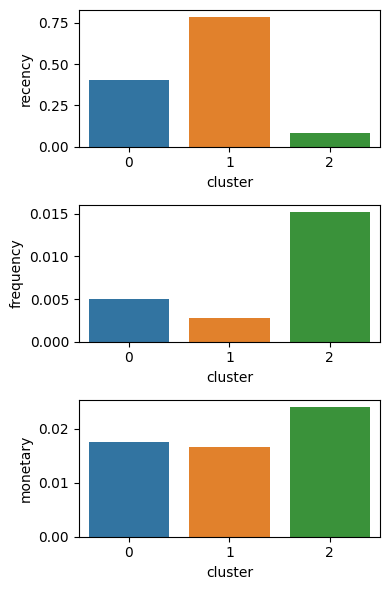

In [19]:
cluster_mean = fin_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().reset_index()

fig, axes = plt.subplots(nrows=3, figsize=(4, 6))

sns.barplot(cluster_mean, x='cluster', y='recency', ax=axes[0])
sns.barplot(cluster_mean, x='cluster', y='frequency', ax=axes[1])
sns.barplot(cluster_mean, x='cluster', y='monetary', ax=axes[2])

plt.tight_layout()

In [20]:
fin_df['cluster'].value_counts()

2    2922
0     816
1     634
Name: cluster, dtype: int64

**Cluster 0 has landed in the mid range for all three features, these might be our regular customer, that can be encouraged to be more engaged. And maybe there are things we can improve for them.**

**Cluster 1 customers shopped not very recently (note that large recency means more days since their last purchase) and have rather low frequency, yet have similar monetary value as cluster 0. These might be some old customers that have quite good purchace ability but became inactive for some reasons, it might be a good idea to figure out why they haven't shopped here for a while.**

**Cluster 2 customers shopped recently, with high frequency and monetary, this means that these are the loyal customers that we want to keep.**

**Good news is the shop has mostly loyal customers (cluster 2) and some regulars (cluster 0), and about 600 old customers that maybe can be brought back.**